## Introduction

This notebook demonstrates the use of [ViennaFold](https://www.tbi.univie.ac.at/RNA/) to calculate the folding energy of two RNA sequences and generate a delta energy adjacency matrix. The delta energy matrix captures the difference in minimum free energy (MFE) between pairs of RNA sequences, providing insights into the stability and similarity of their secondary structures.

### Workflow
1. **Load RNA sequences**: Import two or more RNA sequences for analysis.
2. **Run ViennaFold**: Use the `RNAfold` tool from ViennaFold to compute the MFE for each sequence.
3. **Compute Delta Energy Matrix**: Calculate the pairwise difference in MFE values between each sequence, resulting in an adjacency matrix.
4. **Visualize the Results**: Display the delta energy matrix to highlight sequence similarity and stability differences.

### Requirements
- `ViennaRNA` package installed and accessible via the command line (`RNAfold`).
- Python libraries: `numpy`, `pandas`, and `matplotlib` for matrix manipulation and visualization.

Follow the steps below to execute ViennaFold and interpret the delta energy adjacency matrix.


In [1]:
# Import libs

import random

import matplotlib.pyplot as plt
import numpy as np
import RNA
import seaborn as sns


In [2]:
# Compute RNA duplex structure and energy

# Define your RNA sequences
seq1 = "GCGCUUCGCAGUGUCUCGCUCUCCUCUUGCC"
seq2 = "GGCAAAGCUCUCGGCGUGGC"

# Compute the duplex structure and energy
duplex = RNA.duplexfold(seq1, seq2)

# Output the results
print("Duplex Structure:", duplex.structure)
print("Duplex Energy:", duplex.energy, "kcal/mol")


Duplex Structure: .(((.(((........(((......(((((&)))))))).....))).)))
Duplex Energy: -12.8 kcal/mol


In [3]:
# Make random RNA sequences

def generate_random_rna_sequences(num_sequences, min_length=20, max_length=30):
    sequences = []
    nucleotides = ['A', 'U', 'C', 'G']
    for _ in range(num_sequences):
        length = random.randint(min_length, max_length)
        seq = ''.join(random.choices(nucleotides, k=length))
        sequences.append(seq)
    return sequences

# Generate two lists of 10 random RNA sequences each
seq_list1 = generate_random_rna_sequences(10)
seq_list2 = generate_random_rna_sequences(10)

# Display the sequences
print("Sequence List 1:")
for seq in seq_list1:
    print(seq)

print("\nSequence List 2:")
for seq in seq_list2:
    print(seq)


Sequence List 1:
AUAGCCCGUUGUUUAGGGUCCUA
CCAAUCCGAUCAUCAGAUCUUCACAAUUC
UGUUGACUCGUCCCCUUGAACCAGGAUUC
UUGGGACGGAACCAUAAGGUG
GUUCUUAACCCUGGACCGAU
CCUGUAAGAAGUAAACGCGAG
GAUAUUUGGUCAUGUAGCUGCUAGACGCGC
UGCACAAUUGCUCCUGAAAAGCC
CCAUUCACUGACGGCGCCUAUCAAAUAGU
GGUAUACAUGCUCGGUAUCUGCGUA

Sequence List 2:
AGGGCGAAGGCGCUGUAAGGUAGU
GGGUAAAGUGCUGCACGACAAAAUAU
ACUGGAACGCUCGCAAACACUUCCUUAC
CUAGAUUACGAUUCAGCGAUAAC
GCGACCCAUACCGGCUUUCCCCCA
GACAGUCGGUAGAUCCACUGUCGUCGUA
ACUUCCCCCCUGCCCCUUACGGC
UCGUUCUUCACAAAACAUACCAGGCU
UAUAUAAAAUUCCAAUUCGGACAAUCGAG
CAUCCUACGUUCUGACUCAUUCC


In [4]:
# Compute Gibbs Free Energy from two sequence arrays

def compute_gibbs_free_energy_matrix(seq_list1, seq_list2, verbose=False):
    num_seq1 = len(seq_list1)
    num_seq2 = len(seq_list2)
    energy_matrix = np.zeros((num_seq1, num_seq2))
    
    for i, seq1 in enumerate(seq_list1):
        print(i, end="\r")
        for j, seq2 in enumerate(seq_list2):
            # Compute the duplex energy
            duplex = RNA.duplexfold(seq1, seq2)
            energy = duplex.energy
            energy_matrix[i, j] = energy
            if verbose:
                print(f"Computed energy between seq1[{i}] and seq2[{j}]: {energy} kcal/mol")
    
    return energy_matrix


# Compute the energy matrix
energy_matrix = compute_gibbs_free_energy_matrix(seq_list1, seq_list1, verbose=False)


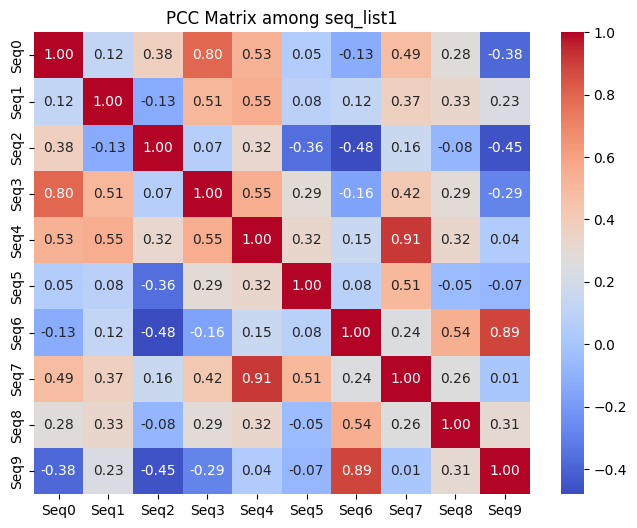

In [5]:
# Now compute PCC of Gibbs free energy matrix

def compute_pcc_matrix_rows(energy_matrix):
    pcc_matrix = np.corrcoef(energy_matrix)
    return pcc_matrix

def compute_pcc_matrix_columns(energy_matrix):
    pcc_matrix = np.corrcoef(energy_matrix.T)
    return pcc_matrix

def plot_pcc_matrix(pcc_matrix, labels=None, title='PCC Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pcc_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()
    
# Compute the PCC matrix among sequences in seq_list1
pcc_matrix_seq1 = compute_pcc_matrix_rows(energy_matrix)

# Plot the PCC matrix
labels_seq1 = [f'Seq{i}' for i in range(len(seq_list1))]
plot_pcc_matrix(pcc_matrix_seq1, labels=labels_seq1, title='PCC Matrix among seq_list1')


## Parse RNA sequence JSON files and use sequence for pairwise comparison analysis

In [7]:
import os
import json

def load_json_files_to_dict(directory):
    """
    Load JSON files from a directory into a dictionary.
    Each JSON file is expected to contain an 'id' key.
    The resulting dictionary will have these 'id's as keys,
    and the corresponding JSON data as values.

    Parameters:
        directory (str): Path to the directory containing JSON files.

    Returns:
        dict: Dictionary with 'id' as keys and JSON data as values.
    """
    json_dict = {}

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                try:
                    # Load the JSON data from the file
                    data = json.load(f)
                    # Extract the 'id' value to use as the new key
                    key = data.get('rnacentral_id')
                    if key is not None:
                        json_dict[key] = data
                    else:
                        print(f"Warning: File {filename} does not contain 'id' key.")
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in file {filename}: {e}")
    return json_dict

directory = './data/json/sequence'
seq_dict = load_json_files_to_dict(directory)
# print("Loaded data for ids:", list(result_dict.keys()))


In [17]:
import os
import json
import random
import numpy as np
import pandas as pd
import RNA
from joblib import Parallel, delayed
from tqdm import tqdm
from joblib import parallel_backend

def load_json_files_to_dict(directory):
    """
    Load JSON files from a directory into a dictionary.
    Each JSON file is expected to contain an 'id' key.
    The resulting dictionary will have these 'id's as keys,
    and the corresponding JSON data as values.
    """
    json_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                try:
                    data = json.load(f)
                    key = data.get('rnacentral_id')
                    if key is not None:
                        json_dict[key] = data
                    else:
                        print(f"Warning: File {filename} does not contain 'id' key.")
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in file {filename}: {e}")
    return json_dict

def compute_energy_row(seq1, seq_list2):
    """
    Compute the Gibbs free energies for a single sequence in seq_list1
    against all sequences in seq_list2.
    
    Parameters:
        seq1 (str): A single RNA sequence from seq_list1.
        seq_list2 (list of str): List of RNA sequences in seq_list2.
    
    Returns:
        list: A list of Gibbs free energies for seq1 against all seq_list2 sequences.
    """
    energies = []
    for seq2 in seq_list2:
        duplex = RNA.duplexfold(seq1, seq2)
        energies.append(duplex.energy)
    return energies

def compute_gibbs_free_energy_matrix_by_row(seq_list1, seq_list2, num_jobs=-1, verbose=False):
    """
    Compute an adjacency matrix of Gibbs free energies between two lists of RNA sequences using joblib.
    Each row (one sequence in seq_list1 vs. all sequences in seq_list2) is processed as a single job.
    
    Parameters:
        seq_list1 (list of str): First list of RNA sequences (rows).
        seq_list2 (list of str): Second list of RNA sequences (columns).
        num_jobs (int): The maximum number of concurrently running jobs. Defaults to -1 (all processors).
        verbose (bool): If True, prints progress information.
    
    Returns:
        numpy.ndarray: A 2D array containing the Gibbs free energies.
    """
    num_seq1 = len(seq_list1)
    num_seq2 = len(seq_list2)
    energy_matrix = np.zeros((num_seq1, num_seq2))

    # Use tqdm for progress tracking at the row level
    with parallel_backend('loky', n_jobs=num_jobs):
        results = Parallel()(
            delayed(compute_energy_row)(seq1, seq_list2) for seq1 in tqdm(seq_list1, desc="Processing rows")
        )

    # Convert list of rows to a 2D matrix
    energy_matrix = np.array(results)

    if verbose:
        print("\nEnergy matrix computation complete.")

    return energy_matrix

# Load the JSON data into a dictionary
directory = './data/json/sequence'
result_dict = load_json_files_to_dict(directory)

# Ensure that the 'sequence' key exists in all entries
result_dict = {k: v for k, v in result_dict.items() if 'sequence' in v}
if not result_dict:
    raise ValueError("No valid sequences found in the JSON files.")

# Get all ids
total_ids = list(result_dict.keys())

# Check if there are enough sequences to sample
if len(total_ids) < 1100:
    raise ValueError("Not enough sequences to sample 1,000 unique ids for seq_list2 and 100 for seq_list1.")

# Step 1: Randomly sample 1,000 ids for seq_list2
seq_list2_ids = random.sample(total_ids, 1000)

# Remove the sampled ids for seq_list2 from total_ids to avoid duplicates in seq_list1
remaining_ids = list(set(total_ids) - set(seq_list2_ids))

# Step 2: Randomly sample 100 ids for seq_list1 from the remaining ids
if len(remaining_ids) < 100:
    raise ValueError("Not enough sequences remaining to sample 100 unique ids for seq_list1 after sampling seq_list2.")
seq_list1_ids = random.sample(remaining_ids, 1000)

# Step 3: Extract sequences for seq_list1
seq_list1 = [result_dict[id]['sequence'] for id in seq_list1_ids]

# Step 4: Extract sequences for seq_list2
seq_list2 = [result_dict[id]['sequence'] for id in seq_list2_ids]

# Optional: You can print the counts to verify
print(f"Total sequences: {len(total_ids)}")
print(f"Seq_list1 (sampled 100): {len(seq_list1)} sequences")
print(f"Seq_list2 (sampled 1,000): {len(seq_list2)} sequences")

# Now, compute the Gibbs free energy matrix using the provided function
print("Computing the Gibbs free energy matrix by row using joblib...")
energy_matrix = compute_gibbs_free_energy_matrix_by_row(seq_list1, seq_list2, num_jobs=-1, verbose=True)
print("Energy matrix computation complete.")

# Create a DataFrame for easier handling and visualization
energy_df = pd.DataFrame(energy_matrix, index=seq_list1_ids, columns=seq_list2_ids)

# Save the energy matrix to a CSV file
energy_df.to_csv('./data/csv/energy_matrix_by_row.csv')

# Display a portion of the energy matrix
print("Sample of the energy matrix:")
print(energy_df.head())


Total sequences: 17400
Seq_list1 (sampled 100): 1000 sequences
Seq_list2 (sampled 1,000): 1000 sequences
Computing the Gibbs free energy matrix by row using joblib...


Processing rows: 100%|████████████████████| 1000/1000 [59:20<00:00,  3.56s/it]



Energy matrix computation complete.
Energy matrix computation complete.
Sample of the energy matrix:
               URS00002525F5  URS00026848DF  URS0002801D92  URS000269168E  \
URS0000C1639A          -49.1          -42.3          -33.4          -54.8   
URS000068DA0C          -32.0          -31.1          -22.6          -27.4   
URS0000C2844D          -40.2          -34.9          -27.4          -39.2   
URS000286A2F0          -65.1          -62.0          -41.3          -74.2   
URS000268AA2E          -48.3          -41.6          -34.4          -47.9   

               URS0000AB4CBC  URS000286A47F  URS0000651148  URS000096475C  \
URS0000C1639A          -53.7          -55.0          -46.3          -27.0   
URS000068DA0C          -33.0          -38.9          -25.4          -15.5   
URS0000C2844D          -41.6          -45.9          -36.2          -30.0   
URS000286A2F0          -64.8          -75.5          -51.5          -30.9   
URS000268AA2E          -57.4          -52.0       

In [6]:
# Import necessary libraries
import pandas as pd

# Read the CSV file 'energy_matrix_by_row.csv' from './data/csv' directory
file_path = './data/csv/energy_matrix_by_row.csv'
energy_df = pd.read_csv(file_path, index_col=0)

# Display the first few rows of the dataframe
energy_df.head()


,URS00001CA1FA,URS0000C41630,URS0000977283,URS000266D828,URS00006B01FF,URS000000697B,URS000094A7B8,URS00005C5433,URS000277FE93,URS000099028E,...,URS00028CB84A,URS000045F029,URS00006D9A28,URS0000D53E31,URS0000997972,URS00028BFC95,URS000098B6BD,URS0000AA72DB,URS0000BFBF25,URS0002904D10
URS0000131D88,-31.3,-32.8,-51.3,-59.9,-36.8,-41.9,-38.5,-25.4,-71.7,-38.0,...,-59.7,-45.2,-51.2,-36.4,-33.3,-56.0,-43.4,-50.2,-32.5,-71.1
URS00006EFA3D,-33.7,-41.8,-46.2,-49.4,-33.9,-48.0,-46.3,-38.6,-65.8,-47.1,...,-52.3,-40.5,-49.0,-42.4,-33.2,-54.9,-48.5,-54.8,-34.5,-68.8
URS000290BBCC,-43.8,-50.3,-41.1,-57.4,-46.3,-45.3,-49.8,-31.3,-67.8,-52.2,...,-53.2,-48.5,-59.3,-49.5,-42.2,-60.0,-47.5,-51.4,-40.9,-75.4
URS00003CD6B6,-21.8,-18.7,-22.0,-26.5,-18.5,-29.9,-26.2,-18.3,-34.7,-27.1,...,-46.3,-26.0,-28.5,-38.2,-22.2,-29.0,-16.5,-23.9,-15.3,-29.0
URS00009853BE,-52.6,-35.4,-37.0,-42.5,-36.5,-39.1,-37.8,-24.4,-60.0,-32.4,...,-44.5,-38.6,-54.6,-36.2,-31.2,-40.0,-35.3,-54.6,-25.9,-58.1


In [18]:
# Compute the PCC matrix of the energy DataFrame
pcc_matrix = energy_df.T.corr()

# # Display the PCC matrix
# print("PCC Matrix:")
# print(pcc_matrix)

# Save the PCC matrix to a CSV file if needed
pcc_matrix.to_csv('./data/csv/pcc_matrix.csv')


<Figure size 1200x1000 with 0 Axes>

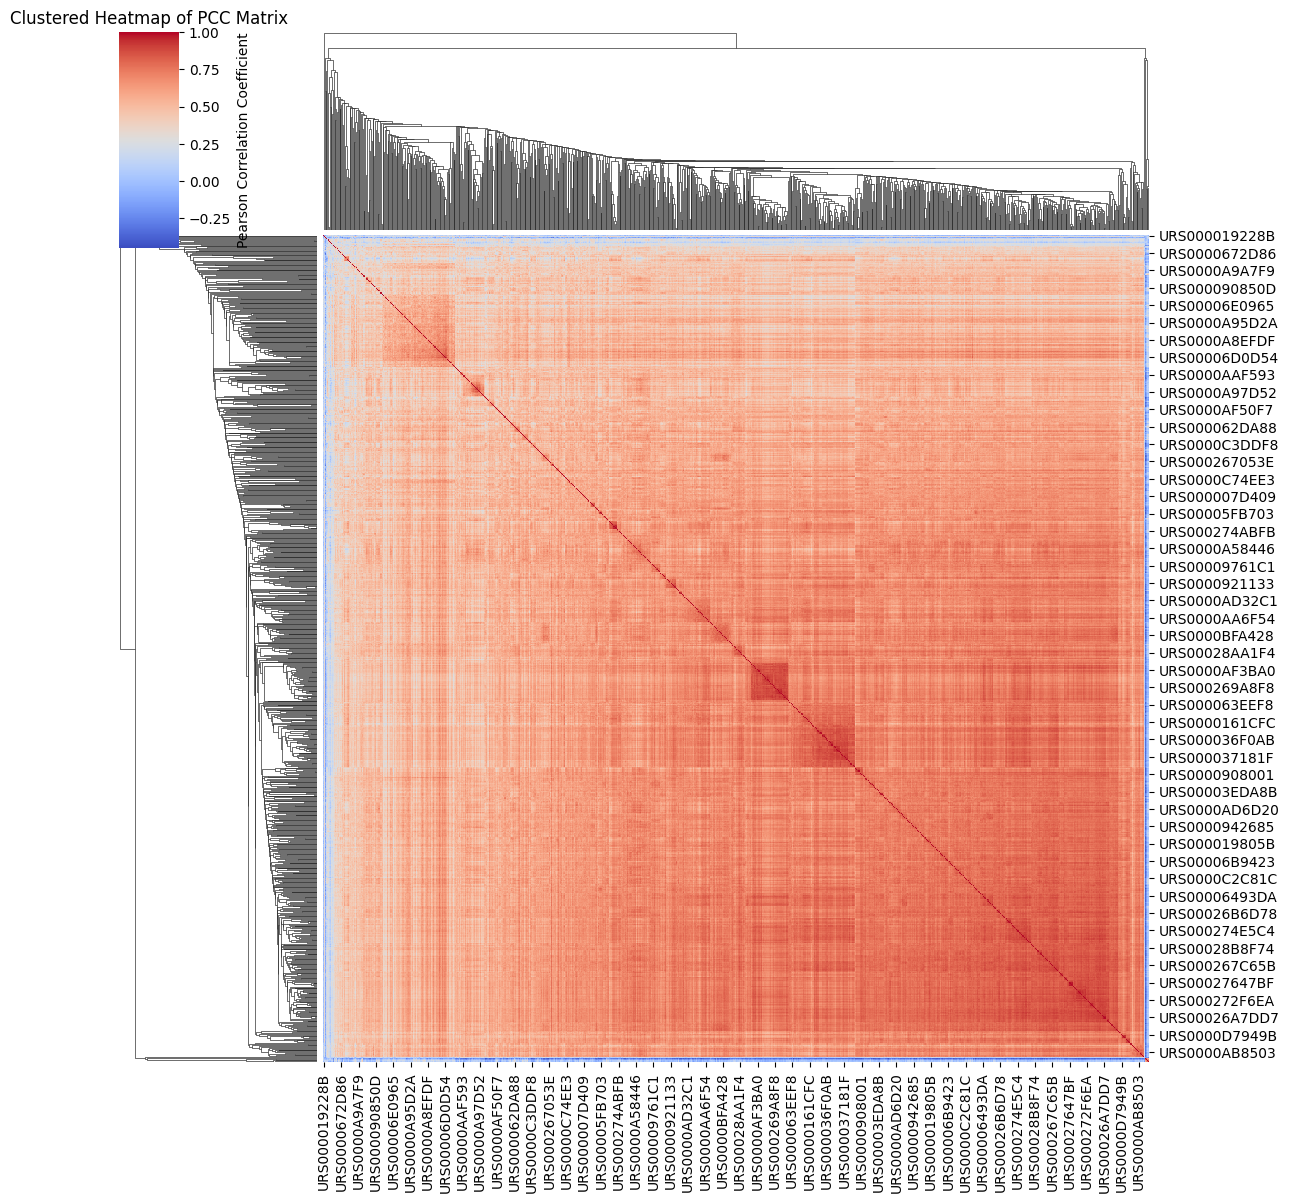

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Step 1: Compute the PCC matrix of the energy DataFrame
pcc_matrix = energy_df.T.corr()

# Step 2: Perform hierarchical clustering
# Convert the correlation matrix to a distance matrix for clustering
# (distance = 1 - correlation)
distance_matrix = 1 - pcc_matrix.abs()

# Compute the linkage (using average linkage method)
# This step will compute the hierarchical clustering based on the distance matrix
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Step 3: Visualize the clustered PCC matrix with a heatmap
plt.figure(figsize=(12, 10))

# Create a heatmap with clustering on rows and columns
sns.clustermap(
    pcc_matrix, 
    row_linkage=linkage_matrix, 
    col_linkage=linkage_matrix, 
    cmap='coolwarm', 
    figsize=(12, 12),
    annot=False,
    cbar_kws={'label': 'Pearson Correlation Coefficient'},
)

plt.title("Clustered Heatmap of PCC Matrix")
plt.show()
